In [1]:
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc
from slepc4py import SLEPc
import pyvista as pv
from dolfinx import mesh, fem, plot

Create domain! A rectangle (1x2) with 10 elements in each direction

In [2]:
rectangle_end_point = (2, 2)
domain = mesh.create_rectangle(comm=MPI.COMM_WORLD, points=[(0, 0), rectangle_end_point], n=(100, 100))
domain

create function space

In [3]:
V = fem.functionspace(domain, ("Lagrange", 1))

In [4]:
# 2. Apply Dirichlet BC: u = 0 on boundary ∂Ω
def boundary(x):
    return np.isclose(x[0], 0.0) | np.isclose(x[0], 2.0) | np.isclose(x[1], 0.0) | np.isclose(x[1], 2.0)

In [5]:
facets = mesh.locate_entities_boundary(domain, domain.topology.dim - 1, boundary)
dofs = fem.locate_dofs_topological(V, domain.topology.dim - 1, facets)
bc = fem.dirichletbc(PETSc.ScalarType(0), dofs, V) # drichlet boundary conditions

In [6]:
# 3. Define bilinear and linear forms
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
a = fem.form(ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx)
m = fem.form(ufl.inner(u, v) * ufl.dx)

In [8]:
import dolfinx.fem.petsc
# 4. Assemble matrices A and M
A = fem.petsc.assemble_matrix(a, bcs=[bc]) #boundary condition only on stiffness matrix
A.assemble()
M = fem.petsc.assemble_matrix(m)
M.assemble()

In [9]:
print("A nnz:", A.getInfo())
print("M nnz:", M.getInfo())


A nnz: {'block_size': 1.0, 'nz_allocated': 70601.0, 'nz_used': 70601.0, 'nz_unneeded': 0.0, 'memory': 0.0, 'assemblies': 1.0, 'mallocs': 0.0, 'fill_ratio_given': 0.0, 'fill_ratio_needed': 0.0, 'factor_mallocs': 0.0}
M nnz: {'block_size': 1.0, 'nz_allocated': 70601.0, 'nz_used': 70601.0, 'nz_unneeded': 0.0, 'memory': 0.0, 'assemblies': 1.0, 'mallocs': 0.0, 'fill_ratio_given': 0.0, 'fill_ratio_needed': 0.0, 'factor_mallocs': 0.0}


In [10]:
print(A.norm())
print(M.norm())

442.7459768309589
0.021504779830427024


In [13]:
eigen_count = 5 #required smallest eigen values

In [14]:
eigensolver = SLEPc.EPS().create()
eigensolver.setOperators(A, M)
eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP) # General Hermitian
eigensolver.setDimensions(nev=eigen_count)
eigensolver.setTolerances(tol=1e-8)
eigensolver.setWhichEigenpairs(SLEPc.EPS.Which.SMALLEST_REAL)
eigensolver.solve()


In [ ]:
# EPS = SLEPc.EPS().create()
# EPS.setOperators(A, M)
# EPS.setProblemType(SLEPc.EPS.ProblemType.GHEP)  # Generalized Hermitian
# EPS.setDimensions(nev=10)  # Number of eigenvalues
# EPS.setTolerances(tol=1e-8, max_it=1000)

# # Target eigenvalues near a positive value (e.g., 1.0)
# EPS.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_MAGNITUDE)
# target = 1.0
# EPS.setTarget(target)

# # Use shift-and-invert to focus on eigenvalues near the target
# ST = EPS.getST()
# ST.setType(SLEPc.ST.Type.SINVERT)
# ST.setShift(target)

# # Choose a robust solver (Krylov-Schur is default and recommended)
# EPS.setType(SLEPc.EPS.Type.KRYLOVSCHUR)

# # Optional: set from command line options
# # EPS.setFromOptions()

# EPS.solve()

In [ ]:
# # 5. Solve the generalized eigenvalue problem A u = λ M u
# eigensolver = SLEPc.EPS().create()
# eigensolver.setOperators(A, M)
# # eigensolver.setProblemType(SLEPc.EPS.ProblemType.HEP)
# eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP)

# tol = 1e-3
# eigensolver.setTolerances(tol=tol)
# eigensolver.setWhichEigenpairs(SLEPc.EPS.Which.SMALLEST_REAL) #set 1 for maximum eigenvalues

# # eigensolver.setType(SLEPc.EPS.Type.KRYLOVSCHUR)

# # Get ST context from eps
# # st = eigensolver.getST()

# # Set shift-and-invert transformation
# # st.setType(SLEPc.ST.Type.SINVERT)

# eigensolver.setDimensions(nev=5)  # Get 10 eigenvalues
# eigensolver.setFromOptions()
# eigensolver.solve() 

# n_conv = eigensolver.getConverged()
# if MPI.COMM_WORLD.rank == 0:
#     print(f"Number of converged eigenvalues: {n_conv}")


In [16]:
n_conv = eigensolver.getConverged()
if MPI.COMM_WORLD.rank == 0:
    print(f"Number of converged eigenvalues: {n_conv}")

Number of converged eigenvalues: 6


In [ ]:
# # 6. Extract and plot first few eigenfunctions
# if MPI.COMM_WORLD.rank == 0:
#     topology, cell_types, geometry = plot.vtk_mesh(V)
#     points = domain.geometry.x
#     for i in range(n_conv):
#         eigval = eigensolver.getEigenvalue(i)
#         error = eigensolver.computeError(i)
#         print(f"Eigenvalue {i}: {eigval.real:.4f} with Error: {error}")

#         r, _ = A.getVecs()
#         eigensolver.getEigenvector(i, r)

#         uh = fem.Function(V)
#         uh.x.petsc_vec.setArray(r.array)
#         uh.x.petsc_vec.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

#         # Create PyVista grid
#         values = uh.x.array.real
#         grid = pv.UnstructuredGrid(topology, cell_types, points)
#         grid.point_data["u"] = values

#         # Plot
#         plotter = pv.Plotter()
#         plotter.add_mesh(grid, show_edges=True, scalars="u", cmap="jet")
#         # plotter.add_mesh(grid, show_edges=True, scalars="u", cmap="hsv")
#         # plotter.add_mesh(grid, show_edges=True, scalars="u", cmap="rainbow")
#         plotter.view_xy()
#         plotter.add_text(f"Eigenfunction {i}, λ = {eigval:.2f}", font_size=12)
#         plotter.show()


Eigenvalue 0: 4.9360 (Error: 1.70e-08)
Eigenvalue 1: 12.3422 (Error: 6.24e-09)
Eigenvalue 2: 12.3452 (Error: 4.75e-10)
Eigenvalue 3: 19.7587 (Error: 3.35e-10)
Eigenvalue 4: 24.6980 (Error: 2.97e-09)
Eigenvalue 5: 24.6980 (Error: 4.39e-11)


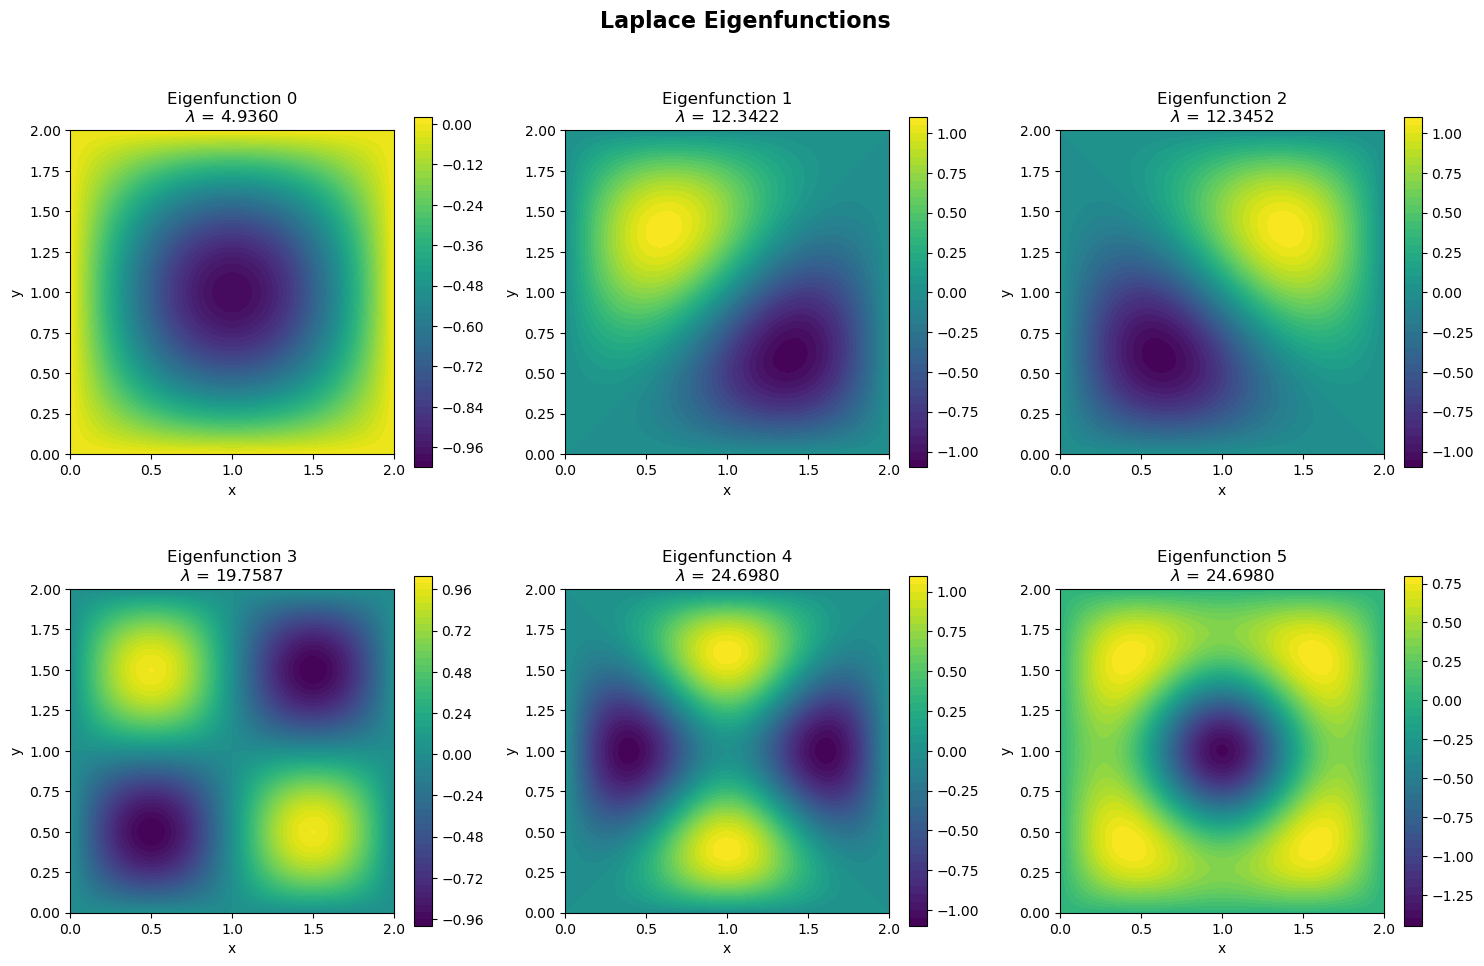

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import dolfinx.plot

# if MPI.COMM_WORLD.rank == 0:
#     # Get mesh topology and geometry for plotting
#     topology, cell_types, geometry = dolfinx.plot.vtk_mesh(domain)
#     points = geometry

#     # Set up grid for plotting multiple eigenfunctions
#     nrows, ncols = 2, 3
#     fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))
#     axes = axes.flatten()

#     for i in range(min(nrows * ncols, n_conv)):
#         eigval = eigensolver.getEigenvalue(i)
#         error = eigensolver.computeError(i)
#         print(f"Eigenvalue {i}: {eigval.real:.4f} (Error: {error:.2e})")

#         r, _ = A.getVecs()
#         eigensolver.getEigenvector(i, r)
#         uh = fem.Function(V)
#         uh.x.petsc_vec.array = r.array
#         uh.x.petsc_vec.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

#         # Plot using matplotlib's tricontourf for smooth color
#         ax = axes[i]
#         tcf = ax.tricontourf(points[:, 0], points[:, 1], uh.x.array.real, levels=50, cmap='viridis')
#         ax.set_title(f"Eigenfunction {i}\n$\lambda$ = {eigval.real:.4f}", fontsize=12)
#         ax.set_xlabel("x")
#         ax.set_ylabel("y")
#         ax.set_aspect('equal')
#         fig.colorbar(tcf, ax=ax, orientation='vertical', shrink=0.8)

#     # Hide unused subplots
#     for j in range(i + 1, nrows * ncols):
#         fig.delaxes(axes[j])

#     plt.suptitle("Laplace Eigenfunctions", fontsize=16, weight='bold')
#     plt.tight_layout(rect=[0, 0, 1, 0.97])
#     plt.show()


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import dolfinx.plot

def plot_eigenfunctions(domain, V, eigensolver, A, n_conv, nev_to_plot=6):
    """
    Plot the first few eigenfunctions for any given domain using matplotlib.
    Parameters:
        domain: dolfinx.mesh.Mesh
        V: dolfinx.fem.FunctionSpace
        eigensolver: SLEPc.EPS
        A: PETSc.Mat (needed for getVecs)
        n_conv: int (number of converged eigenpairs)
        nev_to_plot: int (number of eigenfunctions to plot)
    """
    if MPI.COMM_WORLD.rank != 0:
        return

    topology, cell_types, geometry = dolfinx.plot.vtk_mesh(domain)
    points = geometry

    # Set up grid for plotting multiple eigenfunctions
    nrows = int(np.ceil(np.sqrt(nev_to_plot)))
    ncols = int(np.ceil(nev_to_plot / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()

    for i in range(min(nev_to_plot, n_conv)):
        eigval = eigensolver.getEigenvalue(i)
        error = eigensolver.computeError(i)
        print(f"Eigenvalue {i}: {eigval.real:.4f} (Error: {error:.2e})")

        r, _ = A.getVecs()
        eigensolver.getEigenvector(i, r)
        uh = fem.Function(V)
        uh.x.petsc_vec.array = r.array
        uh.x.petsc_vec.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

        # Plot using matplotlib's tricontourf for smooth color
        ax = axes[i]
        tcf = ax.tricontourf(points[:, 0], points[:, 1], uh.x.array.real, levels=50, cmap='viridis')
        ax.set_title(f"Eigenfunction {i}\n$\lambda$ = {eigval.real:.4f}", fontsize=12)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect('equal')
        fig.colorbar(tcf, ax=ax, orientation='vertical', shrink=0.8)

    # Hide unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    plt.suptitle("Laplace Eigenfunctions", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Usage example (after solving eigenproblem):
# plot_eigenfunctions(domain, V, eigensolver, A, n_conv, nev_to_plot=6)


Eigenvalue 0: 4.9360 (Error: 1.70e-08)
Eigenvalue 1: 12.3422 (Error: 6.24e-09)
Eigenvalue 2: 12.3452 (Error: 4.75e-10)
Eigenvalue 3: 19.7587 (Error: 3.35e-10)
Eigenvalue 4: 24.6980 (Error: 2.97e-09)


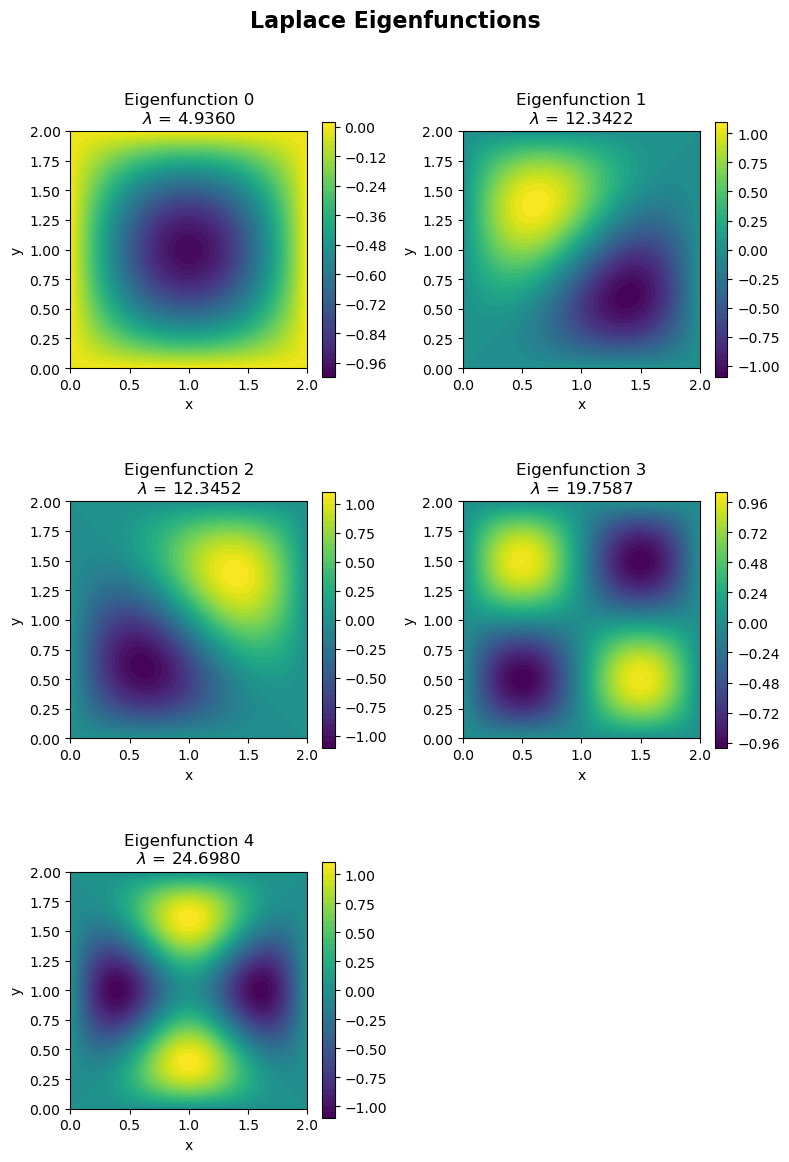

In [25]:
plot_eigenfunctions(domain, V, eigensolver, A, n_conv, nev_to_plot=eigen_count)